In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

TorchMultimodal Tutorial: Finetuning FLAVA
==========================================


Multimodal AI has recently become very popular owing to its ubiquitous
nature, from use cases like image captioning and visual search to more
recent applications like image generation from text. **TorchMultimodal
is a library powered by Pytorch consisting of building blocks and end to
end examples, aiming to enable and accelerate research in
multimodality**.

In this tutorial, we will demonstrate how to use a **pretrained SoTA
model called** [FLAVA](https://arxiv.org/pdf/2112.04482.pdf) **from
TorchMultimodal library to finetune on a multimodal task i.e. visual
question answering** (VQA). The model consists of two unimodal
transformer based encoders for text and image and a multimodal encoder
to combine the two embeddings. It is pretrained using contrastive, image
text matching and text, image and multimodal masking losses.


Installation
============

We will use TextVQA dataset and `bert tokenizer` from Hugging Face for
this tutorial. So you need to install datasets and transformers in
addition to TorchMultimodal.

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>When running this tutorial in Google Colab, install the required packages bycreating a new cell and running the following commands:<pre><code>!pip install torchmultimodal-nightly
!pip install datasets
!pip install transformers</code></pre></p>
</div>


In [ ]:
! pip install torchmultimodal-nightly
! pip install datasets
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.5/256.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 56.2 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=13f236b3026affa29554ac65e9828ce57e567343afb95bcf7683eeb526071c57
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath
  Attempting uninstall: attrs
    Found existing installation: attrs 24.2.0
    Uninstalling attrs-24.2.0:
      Successfully

Steps
=====

1.  Download the Hugging Face dataset to a directory on your computer by
    running the following command:

    ``` {.sourceCode .}
    wget http://dl.fbaipublicfiles.com/pythia/data/vocab.tar.gz
    tar xf vocab.tar.gz
    ```

    <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
    <div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
    <p>If you are running this tutorial in Google Colab, run these commandsin a new cell and prepend these commands with an exclamation mark (!)</p>
    </div>
2.  For this tutorial, we treat VQA as a classification task where the
    inputs are images and question (text) and the output is an answer
    class. So we need to download the vocab file with answer classes and
    create the answer to label mapping.

    We also load the [textvqa
    dataset](https://arxiv.org/pdf/1904.08920.pdf) containing 34602
    training samples (images,questions and answers) from Hugging Face

We see there are 3997 answer classes including a class representing
unknown answers.


In [ ]:
! wget http://dl.fbaipublicfiles.com/pythia/data/vocab.tar.gz

--2024-10-28 03:51:21--  http://dl.fbaipublicfiles.com/pythia/data/vocab.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.167.112.129, 3.167.112.53, 3.167.112.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.167.112.129|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 596389 (582K) [application/gzip]
Saving to: ‘vocab.tar.gz’

vocab.tar.gz        100%[===================>] 582.41K  2.23MB/s    in 0.3s    

2024-10-28 03:51:22 (2.23 MB/s) - ‘vocab.tar.gz’ saved [596389/596389]



In [ ]:
! tar xf vocab.tar.gz

In [ ]:
with open("vocabs/answers_textvqa_more_than_1.txt") as f:
    vocab = f.readlines()

answer_to_idx = {}
for idx, entry in enumerate(vocab):
    answer_to_idx[entry.strip("\n")] = idx
print(len(vocab))
print(vocab[:5])

from datasets import load_dataset
dataset = load_dataset("textvqa")

3997
['<unk>\n', 'nokia\n', 'ec\n', 'virgin\n', '2011\n']
The repository for textvqa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/textvqa.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/34602 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5734 [00:00<?, ? examples/s]

Lets display a sample entry from the dataset:


Question:  what year is shown in the photo?
Answers:  ['2011', '2011', '2011', '2011', '2011', '2011', '2011', '2011', '2011', '2011']


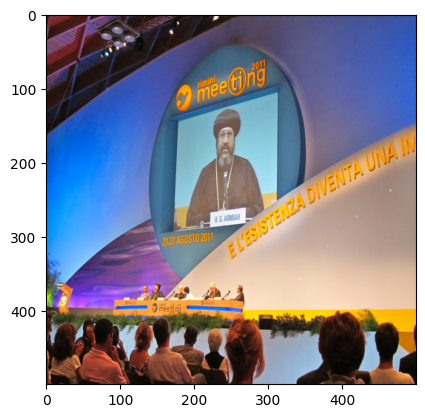

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
idx = 5
print("Question: ", dataset["train"][idx]["question"])
print("Answers: " ,dataset["train"][idx]["answers"])
im = np.asarray(dataset["train"][idx]["image"].resize((500,500)))
plt.imshow(im)
plt.show()

In [ ]:
print(f"Type of dataset: {type(dataset)}")
print(f"Keys of dataset: {dataset.keys()}")
print(f"Type of dataset['train']: {type(dataset['train'])}")

Type of dataset: <class 'datasets.dataset_dict.DatasetDict'>
Keys of dataset: dict_keys(['train', 'validation', 'test'])
Type of dataset['train']: <class 'datasets.arrow_dataset.Dataset'>


In [ ]:
print(f"Length of dataset['train']: {len(dataset['train'])}")
print(f"Length of dataset['validation']: {len(dataset['validation'])}")
print(f"Length of dataset['test']: {len(dataset['test'])}")

Length of dataset['train']: 34602
Length of dataset['validation']: 5000
Length of dataset['test']: 5734


3\. Next, we write the transform function to convert the image and text
into Tensors consumable by our model - For images, we use the transforms
from torchvision to convert to Tensor and resize to uniform sizes - For
text, we tokenize (and pad) them using the `BertTokenizer` from Hugging
Face -For answers (i.e. labels), we take the most frequently occurring
answer as the label to train with:


In [ ]:
import torch
from torchvision import transforms
from collections import defaultdict
from transformers import BertTokenizer
from functools import partial

def transform(tokenizer, input):
    batch = {}
    image_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize([224,224])])
    image = image_transform(input["image"][0].convert("RGB"))
    batch["image"] = [image]

    tokenized=tokenizer(input["question"],return_tensors='pt',padding="max_length",max_length=512)
    batch.update(tokenized)


    ans_to_count = defaultdict(int)
    for ans in input["answers"][0]:
        ans_to_count[ans] += 1
    max_value = max(ans_to_count, key=ans_to_count.get)
    ans_idx = answer_to_idx.get(max_value,0)
    batch["answers"] = torch.as_tensor([ans_idx])
    return batch

tokenizer=BertTokenizer.from_pretrained("bert-base-uncased",padding="max_length",max_length=512)
transform=partial(transform,tokenizer)
dataset.set_transform(transform)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


4\. Finally, we import the `flava_model_for_classification` from
`torchmultimodal`. It loads the pretrained FLAVA checkpoint by default
and includes a classification head.

The model forward function passes the image through the visual encoder
and the question through the text encoder. The image and question
embeddings are then passed through the multimodal encoder. The final
embedding corresponding to the CLS token is passed through a MLP head
which finally gives the probability distribution over each possible
answers.


In [ ]:
from torchmultimodal.models.flava.model import flava_model_for_classification
model = flava_model_for_classification(num_classes=len(vocab))

flava_for_pretraining_unified_text_encoder.pt: 1.43GB [00:33, 43.0MB/s]                            
/usr/local/lib/python3.10/dist-packages/torchmultimodal/utils/common.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for a

5\. We put together the dataset and model in a toy training loop to
demonstrate how to train the model for 3 iterations:


In [ ]:
from torch import nn
BATCH_SIZE = 2
MAX_STEPS = 3
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset["train"], batch_size= BATCH_SIZE)
optimizer = torch.optim.AdamW(model.parameters())


epochs = 10
for _ in range(epochs):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        out = model(text = batch["input_ids"], image = batch["image"], labels = batch["answers"])
        loss = out.loss
        loss.backward()
        optimizer.step()
        print(f"Loss at step {idx} = {loss}")
        if idx >= MAX_STEPS-1:
            break

Loss at step 0 = 8.293740272521973
Loss at step 1 = 8.361364364624023
Loss at step 2 = 8.396402359008789
Loss at step 0 = 8.213276863098145
Loss at step 1 = 7.90511417388916
Loss at step 2 = 7.966757297515869
Loss at step 0 = 7.536726951599121
Loss at step 1 = 7.334555625915527
Loss at step 2 = 7.359416484832764
Loss at step 0 = 6.960814952850342
Loss at step 1 = 6.457395076751709
Loss at step 2 = 6.616655349731445
Loss at step 0 = 5.836441993713379
Loss at step 1 = 4.9576334953308105
Loss at step 2 = 6.071484565734863
Loss at step 0 = 4.526588439941406
Loss at step 1 = 4.653017044067383
Loss at step 2 = 4.544331073760986
Loss at step 0 = 2.7371857166290283
Loss at step 1 = 2.2360072135925293
Loss at step 2 = 3.082329273223877
Loss at step 0 = 1.5833442211151123
Loss at step 1 = 1.5927890539169312
Loss at step 2 = 1.66913640499115
Loss at step 0 = 0.998062789440155
Loss at step 1 = 1.0728248357772827
Loss at step 2 = 1.7481307983398438
Loss at step 0 = 1.1061830520629883
Loss at step 1

In [ ]:
# Assuming 'vocab' is the list that contains your answers
def decode_predictions(output):
    """
    Decodes the model output into sentences/answers using the vocabulary.

    :param output: The output from the model containing logits.
    :return: The predicted answer in string format.
    """
    # Extract logits from the output
    logits = output.logits  # Shape: (batch_size, num_classes)

    # Get the predicted index (class with highest score) for each example in the batch
    predicted_indices = torch.argmax(logits, dim=-1)  # Shape: (batch_size,)

    # Map the predicted indices to answers
    predicted_answers = [vocab[idx].strip("\n") for idx in predicted_indices]

    return predicted_answers


In [ ]:
# Decode predictions into sentences
decoded_predictions = decode_predictions(out)
print(f"Predicted Answers at step {idx}: {decoded_predictions}")

Predicted Answers at step 2: ['nokia']


5. Push to HuggingFace

In [ ]:
! pip install huggingface_hub

In [ ]:
from huggingface_hub import HfApi, HfFolder, Repository
from huggingface_hub import notebook_login

# Login to Hugging Face using the API token
notebook_login()  # It will prompt you to enter your token

In [ ]:
import json
import os
import torch

# Specify directories to save model and tokenizer
model_dir = "flava_multimodal_model"
os.makedirs(model_dir, exist_ok=True)

# Save the model
torch.save(model.state_dict(), os.path.join(model_dir, "pytorch_model.bin"))

# Save the tokenizer
tokenizer.save_pretrained(model_dir)

# Optionally, save additional configuration files if needed
# Example: Save a config file (optional)
config = {
    "num_classes": len(vocab),
    "tokenizer": "bert-base-uncased",
    "model_type": "flava"
}
with open(os.path.join(model_dir, "config.json"), "w") as f:
    json.dump(config, f)


In [ ]:
from huggingface_hub import HfApi, HfFolder

# Replace 'eagle0504' with your Hugging Face username
USERNAME = "eagle0504"
MODEL_NAME = "flava-textvqa-model"
FULL_MODEL_NAME = f"{USERNAME}/{MODEL_NAME}"

# Create a new repository on Hugging Face
api = HfApi()
api.create_repo(repo_id=MODEL_NAME, exist_ok=True)  # Use 'repo_id' instead of 'name'

# Upload the model directory to Hugging Face
from huggingface_hub import upload_folder

upload_folder(
    folder_path=model_dir,
    repo_id=FULL_MODEL_NAME,
    repo_type="model"
)


pytorch_model.bin:   0%|          | 0.00/980M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/eagle0504/flava-textvqa-model/commit/163fa2d360f10e9a307b6f8e88276aaf93124035', commit_message='Upload folder using huggingface_hub', commit_description='', oid='163fa2d360f10e9a307b6f8e88276aaf93124035', pr_url=None, pr_revision=None, pr_num=None)

6. Inference

In [ ]:
with open("vocabs/answers_textvqa_more_than_1.txt") as f:
    vocab = f.readlines()

In [ ]:
import torch
from torchmultimodal.models.flava.model import flava_model_for_classification
from transformers import BertTokenizer
from huggingface_hub import hf_hub_download

# Load the tokenizer from the Hugging Face repository
tokenizer = BertTokenizer.from_pretrained("eagle0504/flava-textvqa-model")

# Load the model weights from the Hugging Face repository
model_dir = "flava_multimodal_model"
model_path = hf_hub_download(repo_id="eagle0504/flava-textvqa-model", filename="pytorch_model.bin")

# Initialize the FLAVA model for classification
model = flava_model_for_classification(num_classes=len(vocab))
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

/usr/local/lib/python3.10/dist-packages/torchmultimodal/utils/common.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(local_path, map_location=t

FLAVAForClassification(
  (model): FLAVAModel(
    (image_encoder): ImageTransformer(
      (embeddings): ImageEmbeddings(
        (patch_embeddings): PatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): TransformerEncoder(
        (layer): ModuleList(
          (0-11): 12 x TransformerEncoderLayer(
            (attention): MultiHeadAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (output): Linear(in_features=768, out_features=768, bias=True)
              (attn): SelfAttention()
            )
            (attention_dropout): Dropout(p=0.0, inplace=False)
            (feedforward): MLP(
              (model): Sequential(
                (0): Linear(in_features=768

In [ ]:
from PIL import Image
from torchvision import transforms

# Load and preprocess the image
image_path = "profile_yiqiao.jpg"  # Replace with your local image file
image = Image.open(image_path).convert("RGB")

# Preprocess the image (resize to 224x224 and convert to tensor)
image_transform = transforms.Compose([transforms.Resize([224, 224]), transforms.ToTensor()])
image_tensor = image_transform(image).unsqueeze(0)  # Add batch dimension

In [ ]:
# Tokenize the question or sentence
sentence = "What is shown in the image?"  # Replace with your specific question
text_inputs = tokenizer(sentence, return_tensors="pt", padding="max_length", max_length=512)

# Extract the required fields from text_inputs
input_ids = text_inputs["input_ids"]
attention_mask = text_inputs["attention_mask"]

In [ ]:
out = model(text = batch["input_ids"], image = batch["image"], labels = batch["answers"])

Error during inference: 'FLAVAForClassification' object has no attribute 'get_logits'


Conclusion
==========

This tutorial introduced the basics around how to finetune on a
multimodal task using FLAVA from TorchMultimodal. Please also check out
other examples from the library like
[MDETR](https://github.com/facebookresearch/multimodal/tree/main/torchmultimodal/models/mdetr)
which is a multimodal model for object detection and
[Omnivore](https://github.com/facebookresearch/multimodal/blob/main/torchmultimodal/models/omnivore.py)
which is multitask model spanning image, video and 3d classification.
